In [1]:
import json
import numpy as np
import pandas as pd

In [2]:
all_utterances = pd.read_csv('utterances.csv').set_index('id')

In [3]:
all_advocates = pd.read_excel('advocates.xlsx').set_index('id')

In [4]:
all_convos = pd.read_excel('all_convos.xlsx').set_index('id')
all_convos['meta.advocates'] = all_convos['meta.advocates'].apply(eval)

## Chunks

In [246]:
def get_chunks_from_utterances(convo_id, convo_utts):
  chunks = []
  
  chunk_no = 0
  chunk_start = 0
  
  cur_chunk = []
  cur_advocate = None
  cur_justice = None

  while chunk_start < len(convo_utts):
    # greedily extract chunk
    speaker = convo_utts.iloc[chunk_start]['speaker']
    speaker_type = convo_utts.iloc[chunk_start]['meta.speaker_type']
    
    if speaker_type != 'A':
      # chunks should begin with an advocate speaking
      chunk_start += 1
      continue
    
    # otherwise, begin a new chunk
    cur_advocate = speaker

    chunk_end = chunk_start
    while chunk_end < len(convo_utts):
      utt_id = convo_utts.utterance_id[chunk_end]
      
      speaker2 = convo_utts.iloc[chunk_end]['speaker']
      speaker2_type = convo_utts.iloc[chunk_end]['meta.speaker_type']

      if speaker2_type not in ['A', 'J']:
        # ex. <INAUDIBLE>
        break
      elif speaker2_type == 'A' and speaker2 != cur_advocate:
        # chunks should have only 1 advocate
        break
      elif speaker2_type == 'J' and speaker2 != cur_justice:
        if cur_justice is not None:
          # chunks should have only 1 justice
          break
        else:
          # this is the first time we've encountered a new justice
          cur_justice = speaker2

      cur_chunk.append(utt_id)
      chunk_end += 1
    
    if len(cur_chunk) >= 4 and cur_advocate is not None and cur_justice is not None:
      # chunks must have at least 4 utterances
      chunk_df = pd.DataFrame(dict(
        conversation_id=convo_id,
        chunk_no=chunk_no,
        utterance_id=cur_chunk,
        advocate_id=cur_advocate,
        justice_id=cur_justice
      ))

      merged = chunk_df.merge(convo_utts, on='utterance_id')
      chunk_df['speaker_type'] = merged['meta.speaker_type']
      chunk_df['interrupted'] = merged.text.str[-2:].isin(['..', '--'])
      # a token is matched by the following regex, which matches words (allowing apostrophes) and floating point numbers.
      chunk_df['n_tokens'] = merged.text.str.count(r"([A-Za-z]+('[A-Za-z]+)?)|([-]?([0-9]*[.])?[0-9]+)")

      chunks.append(chunk_df)
      # allow the next chunk to start using the end of this chunk
      chunk_start = chunk_end - 1 
      chunk_no += 1
    else:
      # try to start a chunk at the next utterance
      chunk_start += 1
    
    cur_chunk = []
    cur_advocate = None
    cur_justice = None
  
  if len(chunks) > 0:
    return pd.concat(chunks)
  else:
    return None

In [253]:
from IPython.display import clear_output
dfs = []
i = 0
is_convo_post_1982 = all_convos['meta.case_id'].apply(lambda id: int(id.split('_')[0])) >= 1982

for convo_id in all_convos[is_convo_post_1982].index:
  if i % 100 == 0:
    clear_output()
    print(i, '/', is_convo_post_1982.sum())
  i += 1
  convo_utts = all_utterances.query('conversation_id == @convo_id') \
    .reset_index() \
    .rename(columns={'id': 'utterance_id'})
  if (chunks := get_chunks_from_utterances(convo_id, convo_utts)) is not None:
    dfs.append(chunks)

clear_output()
print('Done.')

chunks = pd.concat(dfs)

Done.


In [254]:
chunks.to_csv('/flatfiles/chunks_v2.csv')

In [256]:
chunks

,conversation_id,chunk_no,utterance_id,advocate_id,justice_id,speaker_type,interrupted,n_tokens
0,18242,0,18242__0_003,alan_g_segedy,j__sandra_day_oconnor,A,True,518
1,18242,0,18242__0_004,alan_g_segedy,j__sandra_day_oconnor,J,False,19
2,18242,0,18242__0_005,alan_g_segedy,j__sandra_day_oconnor,A,False,4
3,18242,0,18242__0_006,alan_g_segedy,j__sandra_day_oconnor,J,False,3
4,18242,0,18242__0_007,alan_g_segedy,j__sandra_day_oconnor,A,True,6
...,...,...,...,...,...,...,...,...
6,24969,17,24969__2_006,eric_j_feigin,j__sonia_sotomayor,A,False,3
7,24969,17,24969__2_007,eric_j_feigin,j__sonia_sotomayor,J,True,25
8,24969,17,24969__2_008,eric_j_feigin,j__sonia_sotomayor,A,True,3
9,24969,17,24969__2_009,eric_j_feigin,j__sonia_sotomayor,J,False,1


## Interruptions

In [258]:
interruptions = chunks.query('speaker_type == "A"').groupby(['conversation_id', 'chunk_no', 'advocate_id', 'justice_id']).sum()

In [267]:
interruption_rate = interruptions.interrupted / (interruptions.n_tokens / 1000)
interruption_rate.name = 'interruption_rate'

In [268]:
interruption_rate.reset_index().to_csv('flatfiles/interruptions.csv', header=True, index=False)

## Genders

In [299]:
from nameparser import HumanName

advocate_names = all_advocates.rename(columns={'meta.name': 'name'})[['name']]
advocate_names['lastname'] = advocate_names['name'].apply(lambda n: HumanName(n).last)
advocate_names['male_honorific'] = 'Mr. ' + advocate_names['lastname']
advocate_names['female_honorific'] = 'Ms. ' + advocate_names['lastname']

In [300]:
is_convo_post_1982 = all_convos['meta.case_id'].apply(lambda id: int(id.split('_')[0])) >= 1982

In [301]:
advocates_per_convo = all_convos.loc[is_convo_post_1982, 'meta.advocates'].apply(lambda a: a.keys()) \
  .explode() \
  .replace('', None) \
  .dropna() \
  .reset_index() \
  .rename(columns={'id': 'conversation_id', 'meta.advocates': 'advocate_id'})

In [302]:
honorific_utt = all_utterances[all_utterances.speaker.str.contains('j__')].copy().set_index('conversation_id')['text'].str.findall(r'(Mr. \w+|Ms. \w+)')
honorific_utt.name = 'j_honorifics_uttered'

In [303]:
# left merge??
honorifics_uttered = advocates_per_convo.merge(honorific_utt.groupby(level=0).sum().reset_index(), on='conversation_id') \
  .groupby('advocate_id')['j_honorifics_uttered'].sum().apply(set)

In [304]:
names_and_honorifics = advocate_names.join(honorifics_uttered)

In [307]:
names_and_honorifics['matched_mr'] = names_and_honorifics.apply(
  lambda a: a['male_honorific'] in a['j_honorifics_uttered'] 
    if type(a['j_honorifics_uttered']) == set else False, 
  axis=1
)
names_and_honorifics['matched_ms'] = names_and_honorifics.apply(
  lambda a: a['female_honorific'] in a['j_honorifics_uttered']
    if type(a['j_honorifics_uttered']) == set else False, 
  axis=1
)

In [308]:
one_honorific_matched = names_and_honorifics['matched_mr'] ^ names_and_honorifics['matched_ms']
names_and_honorifics['gender'] = np.where(one_honorific_matched, names_and_honorifics['matched_ms'], None) # female = True, male = False

In [313]:
# manually resolve those that are both mr and ms
names_and_honorifics.query('matched_mr & matched_ms').index

Index(['mary_s_burdick', 'lois_g_williams', 'joy_b_shearer', 'jane_r_wettach',
       'constance_e_brooks', 'patricia_a_brannan', 'joel_w_sternman',
       'penny_j_white', 'jerry_l_smith', 'carolou_perry_durham',
       'maria_tankenson_hodge', 'bridget_r_steller', 'paul_m_smith',
       'sally_l_wellman', 'gale_norton', 'carley_j_ingram',
       'barbara_d_underwood', 'corbett_gordon', 'jon_laramore',
       'allison_m_zieve', 'j_bart_delone', 'margie_j_phelps'],
      dtype='object', name='id')

In [314]:
names_and_honorifics.loc[[
  'mary_s_burdick', 
  'lois_g_williams', 
  'joy_b_shearer', 
  'jane_r_wettach',
  'constance_e_brooks', 
  'patricia_a_brannan', 
  'penny_j_white', 
  'carolou_perry_durham',
  'maria_tankenson_hodge', 
  'bridget_r_steller', 
  'sally_l_wellman', 
  'gale_norton', 
  'carley_j_ingram',
  'barbara_d_underwood', 
  'corbett_gordon', 
  'allison_m_zieve', 
  'margie_j_phelps'
]] = True
names_and_honorifics.loc[[
  'joel_w_sternman',
  'jerry_l_smith',
  'paul_m_smith',
  'jon_laramore'
]] = False

In [316]:
names_and_honorifics['gender'].to_csv('flatfiles/genders.csv')

## Interruptions

In [321]:
genders = pd.read_csv('flatfiles/genders.csv').rename(columns={'id': 'advocate_id'}).set_index('advocate_id').dropna()

In [327]:
interruptions = interruption_rate.to_frame().join(genders)

In [349]:
n_advocates = len(interruptions.reset_index().advocate_id.unique())
n_unmatched_advocates = len(interruptions[interruptions.gender.isna()].reset_index().advocate_id.unique())
print(
  f'{interruptions.gender.isna().sum()} / {len(interruptions)} chunks',
  f'({n_unmatched_advocates} / {n_advocates} advocates corresponding to chunks) do not have a gender. Dropping.'
)
interruptions = interruptions.dropna()

1957 / 78360 chunks (167 / 4055 advocates corresponding to chunks) do not have a gender. Dropping.


In [401]:
print('Most frequent female advocates:')
interruptions.query('gender == True').groupby('advocate_id').interruption_rate.count().sort_values(ascending=False).head(20)

Most frequent female advocates:


advocate_id
lisa_s_blatt           253
beth_s_brinkmann       248
patricia_a_millett     245
maureen_e_mahoney      172
nicole_saharsky        161
barbara_d_underwood    156
deanne_e_maynard       137
pamela_s_karlan        133
sarah_e_harrington     129
barbara_b_mcdowell     127
kathleen_m_sullivan    116
ann_oconnell           113
amy_l_wax              110
rachel_p_kovner         93
leondra_r_kruger        84
elaine_j_goldenberg     75
kathryn_a_oberly        74
ginger_d_anders         71
katherine_p_baldwin     65
danielle_spinelli       65
Name: interruption_rate, dtype: int64

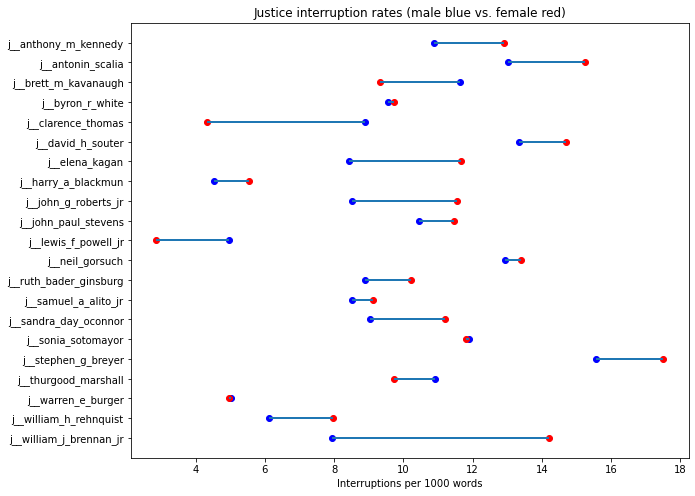

In [391]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

justice_interruption_rates = interruptions.groupby(['justice_id', 'gender']).interruption_rate.mean().unstack('gender').sort_index().dropna()

fig, ax = plt.subplots()
y_pos = np.arange(len(justice_interruption_rates))

lines = []
for i, j in enumerate(justice_interruption_rates.index):
  y = y_pos[i]
  xm = justice_interruption_rates.loc[j, False]
  xf = justice_interruption_rates.loc[j, True]
  plt.plot(xm, y, 'bo')
  plt.plot(xf, y, 'ro')
  lines.append([(xm, y), (xf, y)])
  
fig.set_size_inches(10, 8)
ax.add_collection(LineCollection(lines, linewidths=2))
ax.autoscale()

ax.set_yticks(y_pos, labels=justice_interruption_rates.index)
ax.invert_yaxis()
ax.set_xlabel('Interruptions per 1000 words')
ax.set_title('Justice interruption rates (male blue vs. female red)')

plt.show()